First thing we do is import all package we needed, eg. MEEP & numpy for calculation , pyplot for plotting.
In this case I also import random for randomise sources and time to record calculation time, and I import silver (Ag) and silicon (Si) parameter from meep for simplify calculation.

In [1]:
import meep as mp                   
import numpy as np
from matplotlib import pyplot as plt
from meep.materials import Ag,Si,Au
import random
import math
import time
from IPython.display import Video   

Then, we set up a  parameter section. whenever we need to change a parameter, we do it here. So that you dont have to change everything. 

In [2]:
#parameter
start_time = time.time()
T = 500               # unit of time for simulation
#geometry parameter
x = mp.inf           #x of blocks
y = mp.inf           #y of blocks
z = mp.inf           #z of blocks
N = 9                #number of source
a = 1                #lattice constant in x
b = 1                #lattice constant in y
c = 0                #lattice constant in z

#cell
resolution = 70                          #resolution
cx = a                                    #x of cell
cy = b                                    #y of cell
cz = c                                    #z of cell              
dpml = 0                                  #thickness of PML

#geometry position
r = a/4                                  #radius of cylinder
h = c/2                                  #height of cylinder
A = np.pi * r *r                           # Area of material
xc = np.sqrt(A)                           #x of cube
yc = xc                                  #y of cube
zc = xc                                  #z of cube
xb = 0                                   #x-center of base(always 0)
yb = 0                                   #y-center of base(always 0)
zb = 0                                   #z-center of base(always 0)
material_base = mp.Medium(epsilon =1)       #base material (air) 

material = mp.Medium(epsilon = 1 , E_susceptibilities = susceptibilities) #geometry material



Then, we set up the cell before putting anything in it.

In [3]:
#cell
cell = mp.Vector3(cx,cy,cz)                         # create a cell with cell size of [cx,cy,cz]
pml_layers = [mp.PML(dpml,direction = mp.X)]        # create a perfect material layer with thickness of dpml, and only in X-direction

We then create a geometry inside the cell for our simulation. When two geometry stack together , the newer material will replace the older part. Which is why we can build a environment base then stack a new geometry on it. Once we set up the cell, meep will repeat the cell infinitely. That means the cell is the lattice of our crystal. We put only one cylinder in the center to create a square lattice crystal.

In [4]:
# the base material on the environment.
base = mp.Block(size = mp.Vector3(x,y,z),           
                center = mp.Vector3(xb,yb,zb),
               material = material_base)
geometry =[base]

In [5]:
#prism

geometry.append(mp.Block(size = mp.Vector3(xc,yc),
                         e1 = mp.Vector3(0.5,0.5),
                         e2 = mp.Vector3(-0.5,0.5),
                           center = mp.Vector3(0,0,0),
                                   material = material)) 

After we create the geometry, now we put our sources. We are calculating plasmonic crystal which mean our geometry material is using metal. An error will occur if a source is inside a metal so we have to be careful about the position of sources to be outside of metal.

In [6]:
#source
sources = [ ]                     # defines sources to add on contents later
sources.append(mp.Source(mp.GaussianSource(frequency=fre,fwidth=df),   # center frequency & frequency width
                             component=component,                      # field polarization 
                             center=mp.Vector3(sx,sy,sz),             # position
                            size = mp.Vector3(0,w,0)))                 # width of source

In [7]:
sources.append(mp.Source(mp.GaussianSource(frequency=fre,fwidth=df),   # center frequency & frequency width
                             component=component,                      # field polarization 
                             center=mp.Vector3(sx,sy,sz),             # position
                            size = mp.Vector3(0,w,0)))                 # width of source


Now we add multiple random sources to excite more mode of the crystal. we create a for-loop that on every loop, it will create 1 source each on four quadrants with position be random number between (0-a/2), and repeat it for N times. we also use a if- to make sure x^2+y^2 > r^2, so that no source be inside metal.

In [8]:
for i in range (N+1):                       #create multiple source
    sx1 = random.uniform(-a/2,a/2)     #x-center of source
    sy1 = random.uniform(-a/2,a/2)     #y-center of source

    
    if  np.square(sx1)+ np.square(sy1)<(r*r):
        sx1 = sx1+r
        sy1 = sy1+r
    sources.append(mp.Source(mp.GaussianSource(frequency=fre,fwidth=df),
                             component=random.choice([mp.Hz, mp.Ey, mp.Ex]),                        # random polarization (TM-mode)
                             center=mp.Vector3(sx1,sy1,sz),                                            # random position
                            size = mp.Vector3(0,w,0)))   


then we create a simulation with all the cell, geometry, sources, we defined.

In [9]:
#simulation
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=sources,
                    k_point=mp.Vector3(0.5,0.5),
                    resolution=resolution)

Before the simulation start, we can draw our cell to make sure the geometry and sources is correct.

-----------
Initializing structure...
time for choose_chunkdivision = 6.79493e-05 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 70
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0)
          size (0.443113,0.443113,0)
          axes (0.707107,0.707107,0), (-0.707107,0.707107,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0251188 s
lorentzian susceptibility: frequency=16.365, gamma=1.95106
lorentzian susceptibility: frequency=7.32593, gamma=0.738804
lorentzian susceptibility: frequency=6.60165, gamma=0.052426
lorentzian susceptibility: frequency=3.61417, gamma=0.364563
lorentzian susceptibility: frequency=0.658148, gamma=3.13427
drude susceptibility: frequency=1e-10, gamma=0.0387146
-----------
Meep: using complex fields.


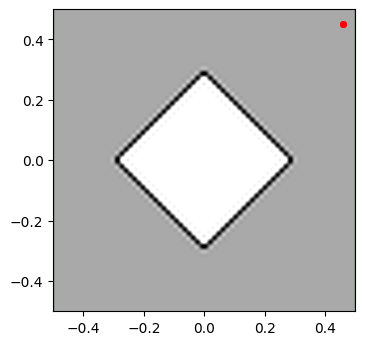

In [10]:
%matplotlib inline
plt.figure(dpi=100)
sim.plot2D()
plt.xlabel('')
plt.ylabel('')
plt.show()

now we run our simulation, for a T unit of time 

In [11]:
sim.run(until=T)

Meep progress: 34.05/500.0 = 6.8% done in 4.0s, 54.8s to go
on time step 4767 (time=34.05), 0.00083952 s/step
Meep progress: 82.43571428571428/500.0 = 16.5% done in 8.0s, 40.5s to go
on time step 11544 (time=82.4571), 0.00059028 s/step
Meep progress: 122.92857142857143/500.0 = 24.6% done in 12.0s, 36.8s to go
on time step 17211 (time=122.936), 0.000705992 s/step
Meep progress: 156.20714285714286/500.0 = 31.2% done in 16.0s, 35.2s to go
on time step 21873 (time=156.236), 0.000858949 s/step
Meep progress: 191.42857142857142/500.0 = 38.3% done in 20.0s, 32.2s to go
on time step 26804 (time=191.457), 0.000811527 s/step
Meep progress: 242.07142857142856/500.0 = 48.4% done in 24.0s, 25.6s to go
on time step 33904 (time=242.171), 0.000563404 s/step
Meep progress: 276.7785714285714/500.0 = 55.4% done in 28.0s, 22.6s to go
on time step 38778 (time=276.986), 0.000820745 s/step
Meep progress: 315.1642857142857/500.0 = 63.0% done in 32.0s, 18.8s to go
on time step 44151 (time=315.364), 0.000744464

after T unit we can draw again our field distribution

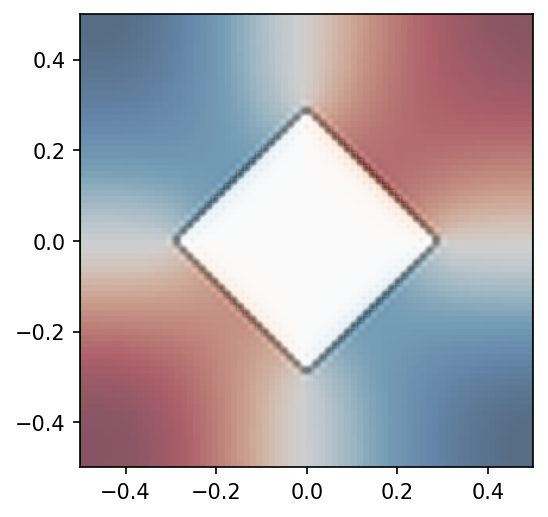

In [12]:
plt.figure(dpi=150)
sim.plot2D(fields= mp.Hz,field_parameters={'alpha':0.5, 'interpolation':'none', 'cmap':'RdBu'},source_parameters={'alpha':0})
plt.xlabel('')
plt.ylabel('')
#plt.title('0.65 MHz')
plt.show()

In [13]:
%%capture
sim.restart_fields()    # reset field distribution we last calculate
k_interp = 22           # number of point for calculate between two k-point

In [14]:
kpts = mp.interpolate(k_interp, [
                                 mp.Vector3(1/(2*a),1/(2*b))
                               ])       # Γ-point          
all_freqs = sim.run_k_points(T, kpts)                       # start calculation the frequency, for all 60 points we just defined
#np.save('Ag_freqs_trape.npy',all_freqs)                           # save the results in case it is needed or PC accidently turned off

Meep progress: 31.3/503.3333332538605 = 6.2% done in 4.0s, 60.4s to go
on time step 4382 (time=31.3), 0.000913368 s/step
Meep progress: 58.65/503.3333332538605 = 11.7% done in 8.0s, 60.7s to go
on time step 8212 (time=58.6571), 0.0010447 s/step
Meep progress: 113.15714285714286/503.3333332538605 = 22.5% done in 12.0s, 41.4s to go
on time step 15850 (time=113.214), 0.000523777 s/step
Meep progress: 157.8357142857143/503.3333332538605 = 31.4% done in 16.0s, 35.0s to go
on time step 22109 (time=157.921), 0.000639168 s/step
Meep progress: 206.60714285714286/503.3333332538605 = 41.0% done in 20.0s, 28.7s to go
on time step 28944 (time=206.743), 0.000585258 s/step
Meep progress: 259.6428571428571/503.3333332538605 = 51.6% done in 24.0s, 22.5s to go
on time step 36364 (time=259.743), 0.000539129 s/step
Meep progress: 310.9714285714286/503.3333332538605 = 61.8% done in 28.0s, 17.3s to go
on time step 43540 (time=311), 0.000557433 s/step
Meep progress: 352.34999999999997/503.3333332538605 = 70.

now we create k1, k2, k3 for plotting our results in k-space, which need to be ratio of 1:1:sqrt(2) for a square lattice plasmonic crystal.

In [15]:
v = round(len(kpts)/3)

k1 = np.linspace(0,1,v)
k2 = np.linspace(1,2,v)
k3 = np.linspace(2,2+np.sqrt(2),v)

IndexError: index 1 is out of bounds for axis 0 with size 0

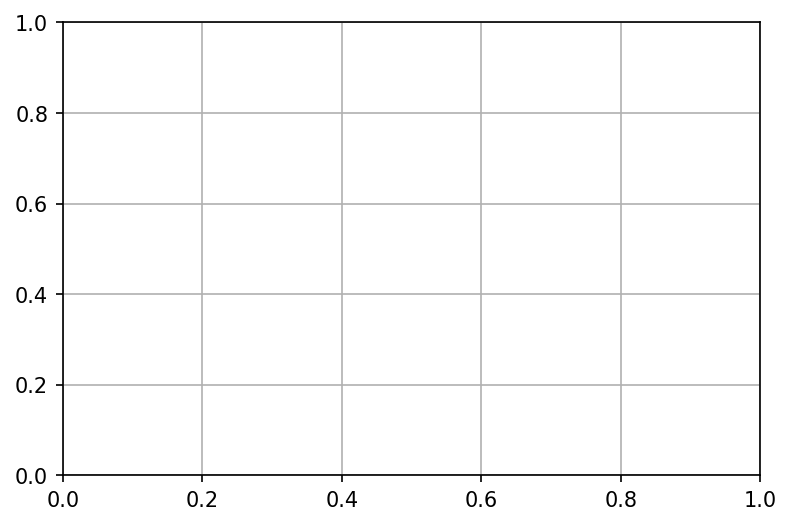

In [16]:
fig = plt.figure(dpi=150)
ax = plt.subplot(111)
for i in range(v):
    for ii in range(len(all_freqs[i])):
        plt.scatter(k1[i],np.real(all_freqs[i][ii]),color='b',marker = '_')
for i in range(v):
    for ii in range(len(all_freqs[i+v])):
        plt.scatter(k2[i],np.real(all_freqs[i+v][ii]),color='b',marker = '_')
for i in range(v):
    for ii in range(len(all_freqs[i+2*v])):
        plt.scatter(k3[i],np.real(all_freqs[i+2*v][ii]),color='b',marker = '_')

plt.grid(True)
plt.xlim(k1[1],k3[-1])
plt.ylim(0,3)
plt.xticks((0,k1[-1],k2[-1],k3[-1]),('Γ', 'X', 'M', 'Γ'))
plt.xticks(fontsize=14)
plt.ylabel('$ frequency  (1/\mu m)$', fontsize = 14)
plt.title('Two-dimensional Plasmonic Crystal TE-mode')

This part, we use the frequency results we just calculate to make some calculation about Quality factor(Q-factor) for each frequency.

In [ ]:
freqs_plot_real=list()
freqs_plot_im=list()
kx_plot=list()
plot_lib=0
freqs_plot_real_M=list()
freqs_plot_im_M=list()


#1
for i in range(len(all_freqs)):                   
    for ii in range(len(all_freqs[i])):            
            freqs_plot_real.append(np.real(all_freqs[i][ii]))
            freqs_plot_im.append(np.imag(all_freqs[i][ii]))
            plot_lib+=1
            
k4 = np.linspace(0,1,len(freqs_plot_real))

freqs_plot_real=np.array(freqs_plot_real)
freqs_plot_im=np.array(freqs_plot_im)
kx_plot=np.array(kx_plot)
           

Q_plot=np.abs(freqs_plot_real/(2*freqs_plot_im))

Q_plot_min=np.min(Q_plot)
Q_plot_max=np.max(Q_plot)

In [ ]:
fig = plt.figure(dpi=100,figsize=(5,5))
ax = plt.subplot(111)
plt.scatter(k4,freqs_plot_real,c=Q_plot,s=20,vmin=Q_plot_min, vmax=Q_plot_max, cmap='jet',marker='_')   

cb=plt.colorbar()

font={'color':'black',
     'size':'16',
      'weight':'normal'
     }
cb.set_label('Q(quality factor)',fontdict=font)




points_in_between = (len(all_freqs[0]) ) / 2       #for gamma k gamma
tick_locs = [(points_in_between*0)+i for i in range(2)]  #know that 0~9



plt.grid(True)

plt.tight_layout()
plt.xlim(0,k4[-1])
plt.ylim(fre-df/2,fre+df/2)
#plt.ylim(0.5,0.6)
plt.ylabel('$ frequency  (1/\mu m)$')
plt.title('TM-mode Square Lattice Plasmonic Crystal')
plt.xticks((0,k4[-1]/3,2*k4[-1]/3,k4[-1]),('Γ', 'X', 'M', 'Γ'))
#fig.savefig('timedomain_DM_sigama_0_0i(gamma)', dpi=fig.dpi)
plt.show()

print(Q_plot_max)

In [ ]:
VIDEO

We also can make a video of our field distribute process , but our field at source is too large at the beginning causing the field to be not obvious at the beginning

In [ ]:
sim.reset_meep()                # reset the field to start from beginning
f = plt.figure(dpi=100)         # size of our video 
Animate = mp.Animate2D(sim, fields=component, f=f, realtime=False, normalize=True,field_parameters={'alpha':0.5, 'interpolation':'none', 'cmap':'RdBu','vmax':0.0001,'vmin':-0.0001})
plt.close()

In [ ]:
sim.run(mp.at_every(0.01,Animate),until = 50)    # get a frame every 0.01 unit for a total of T unit of time
plt.close()

In [ ]:
filename = "1.6_2.mp4"           
Animate.to_mp4(10,filename)   #save a file of our video in your folder

In [ ]:
Video(filename)               # open a file from your folder 

get the total time taken for calculation by time now-start_time we defined at the beginning

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
y1